# Introduction to `scipy.optimize`

[SciPy](https://scipy.org) provides algorithms for optimization, integration, interpolation, eigenvalue problems, algebraic equations, differential equations, statistics and many other classes of problems.
SciPy is a collection of mathematical algorithms and convenience functions built on NumPy. It adds significant power to Python by providing the user with high-level commands and classes for manipulating and visualizing data.

[SciPy optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html#module-scipy.optimize) provides functions for minimizing (or maximizing) objective functions, possibly subject to constraints. It includes solvers for nonlinear problems (with support for both local and global optimization algorithms), linear programing, constrained and nonlinear least-squares, root finding, and curve fitting.


In this notebook, we will learn how to use the `scipy.optimize` module to solve optimization problems.
See: [https://docs.scipy.org/doc/scipy/tutorial/optimize.html](https://docs.scipy.org/doc/scipy/tutorial/optimize.html)

::: {.callout-note}
* This content is based on information from the scipy.optimize package.
* The `scipy.optimize` package provides several commonly used optimization algorithms. A detailed listing is available in `scipy.optimize` (can also be found by `help(scipy.optimize)`).
:::

Common functions and objects, shared across different SciPy optimize solvers, are shown in @tbl-shared-functions.

| Function or Object | Description |
| --- | --- |
| [show_options([solver, method, disp])](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.show_options.html#scipy.optimize.show_options) | Show documentation for additional options of optimization solvers. |
| [OptimizeResult](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html#scipy.optimize.OptimizeResult) | Represents the optimization result. |
| [OptimizeWarning](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeWarning.html#scipy.optimize.OptimizeWarning) | Warning issued by solvers. |
: Common functions and objects, shared across different SciPy optimize solvers {#tbl-shared-functions}

We will introduce unconstrained minimization of multivariate scalar functions in this chapter.
The [minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize) function provides a common interface to unconstrained and constrained minimization algorithms for multivariate scalar functions in `scipy.optimize`. To demonstrate the minimization function, consider the problem of minimizing the Rosenbrock function of *N* variables:

$$
f(J) = \sum_{i=1}^{N-1} 100 (x_{i+1} - x_i^2)^2 + (1 - x_i)^2
$$

The minimum value of this function is 0, which is achieved when \(x_i = 1\).

Note that the Rosenbrock function and its derivatives are included in `scipy.optimize`. The implementations shown in the following sections provide examples of how to define an objective function as well as its Jacobian and Hessian functions. Objective functions in `scipy.optimize` expect a numpy array as their first parameter, which is to be optimized and must return a float value. The exact calling signature must be `f(x, *args)`, where `x` represents a numpy array, and `args` is a tuple of additional arguments supplied to the objective function.

##  Derivative-free Optimization Algorithms

@sec-nelder-mead-simplex-algorithm and @sec-powells-method present two approaches that do not need gradient information to find the minimum. They use function evaluations to find the minimum.

### Nelder-Mead Simplex Algorithm {#sec-nelder-mead-simplex-algorithm}

`method='Nelder-Mead'`: In the example below, the `minimize` routine is used with the *Nelder-Mead* simplex algorithm (selected through the `method` parameter):


In [1]:
import numpy as np
from scipy.optimize import minimize

def rosen(x):
    """The Rosenbrock function"""
    return sum(100.0 * (x[1:] - x[:-1]**2.0)**2.0 + (1 - x[:-1])**2.0)

x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])
res = minimize(rosen, x0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})

print(res.x)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 339
         Function evaluations: 571
[1. 1. 1. 1. 1.]


The simplex algorithm is probably the simplest way to minimize a well-behaved function. It requires only function evaluations and is a good choice for simple minimization problems. However, because it does not use any gradient evaluations, it may take longer to find the minimum.

### Powell's Method {#sec-powells-method}

Another optimization algorithm that needs only function calls to find the minimum is *Powell*'s method, which can be selected by setting the `method` parameter to `'powell'` in the `minimize` function.

To demonstrate how to supply additional arguments to an objective function, let's consider minimizing the Rosenbrock function with an additional scaling factor $a$ and an offset $b$:

$$
f(J, a, b) = \sum_{i=1}^{N-1} a (x_{i+1} - x_i^2)^2 + (1 - x_i)^2 + b
$$

You can achieve this using the `minimize` routine with the example parameters $a=0.5$ and $b=1$:


In [2]:
def rosen_with_args(x, a, b):
    """The Rosenbrock function with additional arguments"""
    return sum(a * (x[1:] - x[:-1]**2.0)**2.0 + (1 - x[:-1])**2.0) + b

x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])
res = minimize(rosen_with_args, x0, method='nelder-mead',
               args=(0.5, 1.), options={'xatol': 1e-8, 'disp': True})

print(res.x)

Optimization terminated successfully.
         Current function value: 1.000000
         Iterations: 319
         Function evaluations: 525
[1.         1.         1.         1.         0.99999999]


As an alternative to using the `args` parameter of `minimize`, you can wrap the objective function in a new function that accepts only `x`. This approach is also useful when it is necessary to pass additional parameters to the objective function as keyword arguments.


In [3]:
def rosen_with_args(x, a, *, b):  # b is a keyword-only argument
    return sum(a * (x[1:] - x[:-1]**2.0)**2.0 + (1 - x[:-1])**2.0) + b

def wrapped_rosen_without_args(x):
    return rosen_with_args(x, 0.5, b=1.)  # pass in `a` and `b`

x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])
res = minimize(wrapped_rosen_without_args, x0, method='nelder-mead',
               options={'xatol': 1e-8,})

print(res.x)

[1.         1.         1.         1.         0.99999999]


Another alternative is to use `functools.partial`.


In [4]:
from functools import partial

partial_rosen = partial(rosen_with_args, a=0.5, b=1.)
res = minimize(partial_rosen, x0, method='nelder-mead',
               options={'xatol': 1e-8,})

print(res.x)

[1.         1.         1.         1.         0.99999999]


## Gradient-based optimization algorithms

### An Introductory Example: Broyden-Fletcher-Goldfarb-Shanno Algorithm (BFGS) {#sec-bfgs-intro}

This section introduces an optimization algorithm that uses gradient information to find the minimum.
The Broyden-Fletcher-Goldfarb-Shanno (BFGS) algorithm (selected by setting `method='BFGS'`) is an optimization algorithm that aims to converge quickly to the solution.
This algorithm uses the gradient of the objective function.
If the gradient is not provided by the user, it is estimated using first-differences. The BFGS method typically requires fewer function calls compared to the simplex algorithm, even when the gradient needs to be estimated.

::: {.callout-note}
#### Example: BFGS
To demonstrate the BFGS algorithm, let's use the Rosenbrock function again.
The gradient of the Rosenbrock function is a vector described by the following mathematical expression:

\begin{align}
\frac{\partial f}{\partial x_j} = \sum_{i=1}^{N} 200(x_i - x_{i-1}^2)(\delta_{i,j} - 2x_{i-1}\delta_{i-1,j}) - 2(1 - x_{i-1})\delta_{i-1,j} \\
= 200(x_j - x_{j-1}^2) - 400x_j(x_{j+1} - x_j^2) - 2(1 - x_j)
\end{align}

This expression is valid for interior derivatives, but special cases are:

$$
\frac{\partial f}{\partial x_0} = -400x_0(x_1 - x_0^2) - 2(1 - x_0)
$$

$$
\frac{\partial f}{\partial x_{N-1}} = 200(x_{N-1} - x_{N-2}^2)
$$

Here's a Python function that computes this gradient:


In [5]:
def rosen_der(x):
    xm = x[1:-1]
    xm_m1 = x[:-2]
    xm_p1 = x[2:]
    der = np.zeros_like(x)
    der[1:-1] = 200*(xm-xm_m1**2) - 400*(xm_p1 - xm**2)*xm - 2*(1-xm)
    der[0] = -400*x[0]*(x[1]-x[0]**2) - 2*(1-x[0])
    der[-1] = 200*(x[-1]-x[-2]**2)
    return der

You can specify this gradient information in the minimize function using the jac parameter as illustrated below:


In [6]:
res = minimize(rosen, x0, method='BFGS', jac=rosen_der,
               options={'disp': True})

print(res.x)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 25
         Function evaluations: 30
         Gradient evaluations: 30
[1.00000004 1.0000001  1.00000021 1.00000044 1.00000092]


:::


### Background and Basics for Gradient-based Optimization

### Gradient

The gradient $\nabla f(J)$ for a scalar function $f(J)$ with $n$ different variables is defined by its partial derivatives:

$$\nabla f(J) = \left[ \frac{\partial f}{\partial x_1}, \frac{\partial f}{\partial x_2}, \ldots, \frac{\partial f}{\partial x_n} \right]$$

### Jacobian Matrix

The Jacobian matrix $J(J)$ for a vector-valued function $F(J) = [f_1(J), f_2(J), \ldots, f_m(J)]$ is defined as:

$J(J) = \begin{bmatrix} \frac{\partial f_1}{\partial x_1} & \frac{\partial f_1}{\partial x_2} & \ldots & \frac{\partial f_1}{\partial x_n} \\ \frac{\partial f_2}{\partial x_1} & \frac{\partial f_2}{\partial x_2} & \ldots & \frac{\partial f_2}{\partial x_n} \\ \vdots & \vdots & \ddots & \vdots \\ \frac{\partial f_m}{\partial x_1} & \frac{\partial f_m}{\partial x_2} & \ldots & \frac{\partial f_m}{\partial x_n} \end{bmatrix}$

It consists of the first order partial derivatives and gives therefore an overview about the gradients of a vector valued function.


::: {.callout-note}
#### Example: Jacobian matrix

Consider a vector-valued function $f : \mathbb{R}^2 \rightarrow \mathbb{R}^3$ defined as follows:
$$f(J) = \begin{bmatrix} x_1^2 + 2x_2 \\ 3x_1 - \sin(x_2) \\ e^{x_1 + x_2} \end{bmatrix}$$

Let's compute the partial derivatives and construct the Jacobian matrix:

$\frac{\partial f_1}{\partial x_1} = 2x_1, \quad \frac{\partial f_1}{\partial x_2} = 2$

$\frac{\partial f_2}{\partial x_1} = 3, \quad \frac{\partial f_2}{\partial x_2} = -\cos(x_2)$

$\frac{\partial f_3}{\partial x_1} = e^{x_1 + x_2}, \quad \frac{\partial f_3}{\partial x_2} = e^{x_1 + x_2}$

So, the Jacobian matrix is:

$$J(J) = \begin{bmatrix} 2x_1 & 2 \\ 3 & -\cos(x_2) \\ e^{x_1 + x_2} & e^{x_1 + x_2} \end{bmatrix}$$

This Jacobian matrix provides information about how small changes in the input variables $x_1$ and $x_2$ affect the corresponding changes in each component of the output vector.

:::


### Hessian Matrix

The Hessian matrix $H(J)$ for a scalar function $f(J)$ is defined as:

$H(J) = \begin{bmatrix} \frac{\partial^2 f}{\partial x_1^2} & \frac{\partial^2 f}{\partial x_1 \partial x_2} & \ldots & \frac{\partial^2 f}{\partial x_1 \partial x_n} \\ \frac{\partial^2 f}{\partial x_2 \partial x_1} & \frac{\partial^2 f}{\partial x_2^2} & \ldots & \frac{\partial^2 f}{\partial x_2 \partial x_n} \\ \vdots & \vdots & \ddots & \vdots \\ \frac{\partial^2 f}{\partial x_n \partial x_1} & \frac{\partial^2 f}{\partial x_n \partial x_2} & \ldots & \frac{\partial^2 f}{\partial x_n^2} \end{bmatrix}$

So, the Hessian matrix consists of the second order dervatives of the function. It provides information about the local curvature of the function with respect to changes in the input variables.

::: {.callout-note}
#### Example: Hessian matrix

Consider a scalar-valued function:
$$f(J) = x_1^2 + 2x_2^2 + \sin(x_1   x_2)$$

The Hessian matrix of this scalar-valued function is the matrix of its second-order partial derivatives with respect to the input variables:
$$H(J) = \begin{bmatrix} \frac{\partial^2 f}{\partial x_1^2} & \frac{\partial^2 f}{\partial x_1 \partial x_2} \\ \frac{\partial^2 f}{\partial x_2 \partial x_1} & \frac{\partial^2 f}{\partial x_2^2} \end{bmatrix}$$

Let's compute the second-order partial derivatives and construct the Hessian matrix:

\begin{align}
\frac{\partial^2 f}{\partial x_1^2} &= 2 + \cos(x_1 x_2) x_2^2\\
\frac{\partial^2 f}{\partial x_1 \partial x_2} &= 2x_1  x_2 \cos(x_1 x_2) - \sin(x_1  x_2)\\
\frac{\partial^2 f}{\partial x_2 \partial x_1} &= 2x_1  x_2  \cos(x_1  x_2) - \sin(x_1  x_2)\\
\frac{\partial^2 f}{\partial x_2^2} &= 4x_2^2 + \cos(x_1  x_2) x_1^2
\end{align}

So, the Hessian matrix is:

$$H(J) = \begin{bmatrix} 2 + \cos(x_1   x_2)   x_2^2 & 2x_1   x_2   \cos(x_1   x_2) - \sin(x_1   x_2) \\ 2x_1   x_2   \cos(x_1   x_2) - \sin(x_1   x_2) & 4x_2^2 + \cos(x_1   x_2)   x_1^2 \end{bmatrix}$$

:::

### Gradient for Optimization

In optimization, the goal is to find the minimum or maximum of a function. Gradient-based optimization methods utilize information about the gradient (or derivative) of the function to guide the search for the optimal solution. This is particularly useful when dealing with complex, high-dimensional functions where an exhaustive search is impractical.

The gradient descent method can be divided in the following steps:

+ **Initialize:** start with an initial guess for the parameters of the function to be optimized.
+ **Compute Gradient:** Calculate the gradient (partial derivatives) of the function with respect to each parameter at the current point. The gradient indicates the direction of the steepest increase in the function.
+ **Update Parameters:** Adjust the parameters in the opposite direction of the gradient, scaled by a learning rate. This step aims to move towards the minimum of the function: 
    * $x_{k+1} = x_k - \alpha \times \nabla f(x_{k})$
    * $x_{x}$ is current parameter vector or point in the parameter space. 
    * $\alpha$ is the learning rate, a positive scalar that determines the step size in each iteration.
    * $\nabla f(x)$ is the gradient of the objective function.
+ **Iterate:** Repeat the above steps until convergence or a predefined number of iterations. Convergence is typically determined when the change in the function value or parameters becomes negligible.

::: {.callout-note}
#### Example: Gradient Descent

Let's consider a simple quadratic function as an example:
$$f(x) = x^2 + 4x + y^2 + 2y + 4.$$

We'll use gradient descent to find the minimum of this function.


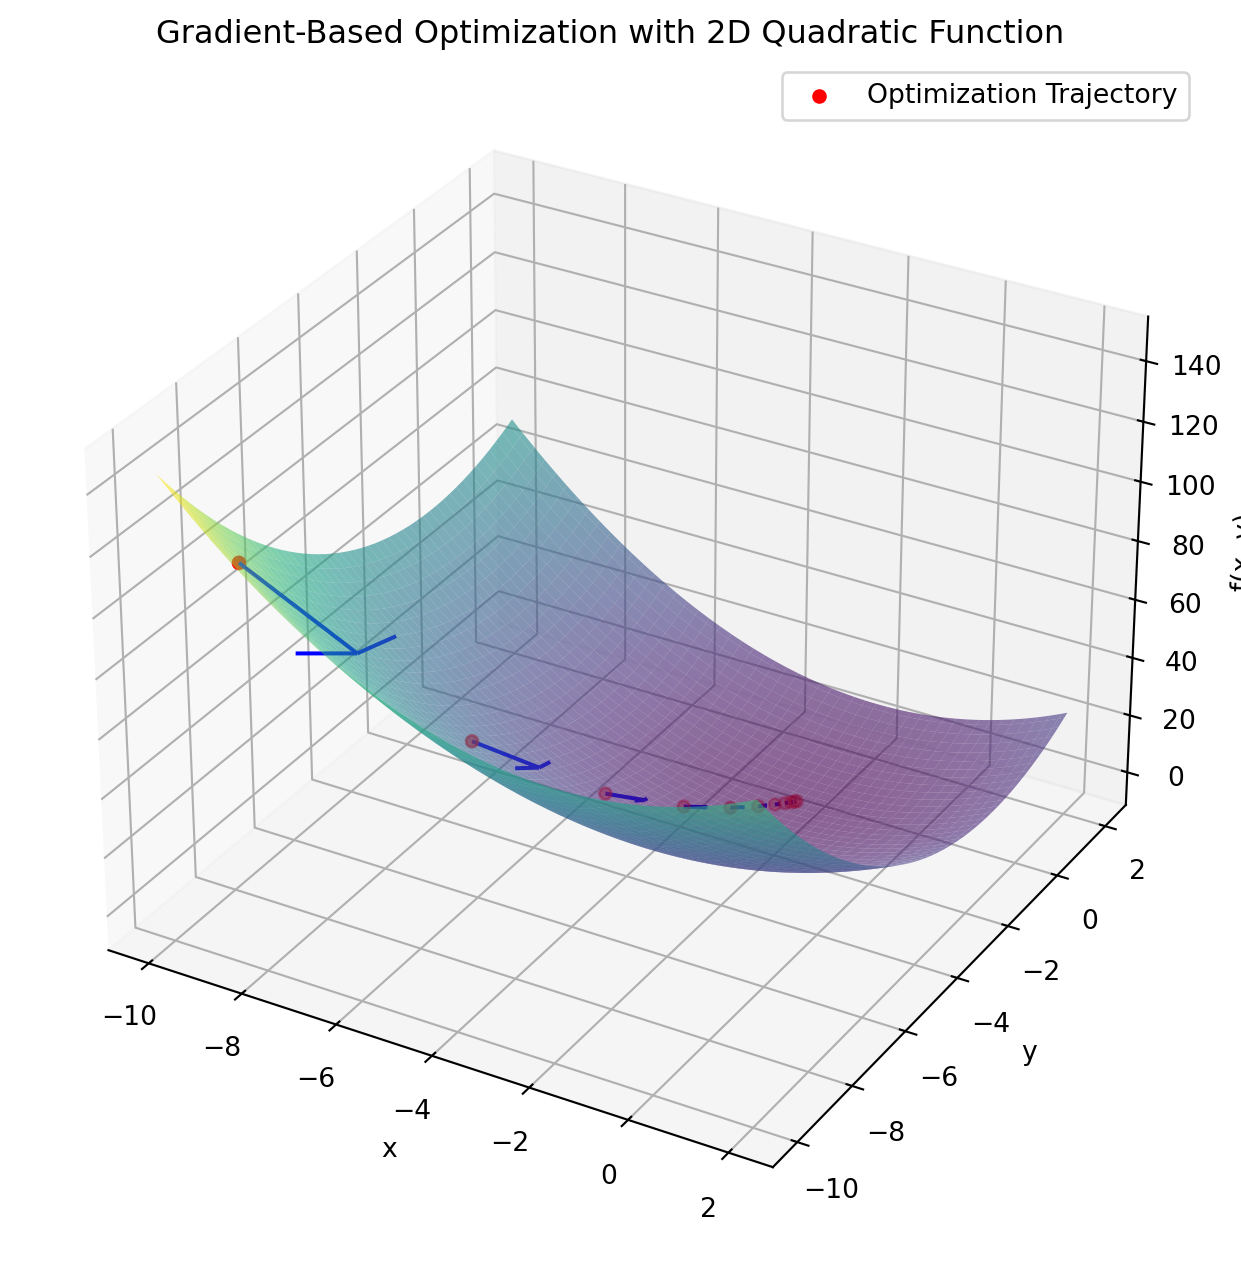

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the quadratic function
def quadratic_function(x, y):
    return x**2 + 4*x + y**2 + 2*y + 4

# Define the gradient of the quadratic function
def gradient_quadratic_function(x, y):
    grad_x = 2*x + 4
    grad_y = 2*y + 2
    return np.array([grad_x, grad_y])

# Gradient Descent for optimization in 2D
def gradient_descent(initial_point, learning_rate, num_iterations):
    points = [np.array(initial_point)]
    
    for _ in range(num_iterations):
        current_point = points[-1]
        gradient = gradient_quadratic_function(*current_point)
        new_point = current_point - learning_rate * gradient
        
        points.append(new_point)
        
    return points

# Visualization of optimization process with 3D surface and consistent arrow sizes
def plot_optimization_process_3d_consistent_arrows(points):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    x_vals = np.linspace(-10, 2, 100)
    y_vals = np.linspace(-10, 2, 100)
    X, Y = np.meshgrid(x_vals, y_vals)
    Z = quadratic_function(X, Y)

    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.6)
    ax.scatter(*zip(*points), [quadratic_function(*p) for p in points], c='red', label='Optimization Trajectory')

    for i in range(len(points) - 1):  
        x, y = points[i]
        dx, dy = points[i + 1] - points[i]
        dz = quadratic_function(*(points[i + 1])) - quadratic_function(*points[i])
        gradient_length = 0.5

        ax.quiver(x, y, quadratic_function(*points[i]), dx, dy, dz, color='blue', length=gradient_length, normalize=False, arrow_length_ratio=0.1)

    ax.set_title('Gradient-Based Optimization with 2D Quadratic Function')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('f(x, y)')
    ax.legend()
    plt.show()

# Initial guess and parameters
initial_guess = [-9.0, -9.0]
learning_rate = 0.2
num_iterations = 10

# Run gradient descent in 2D and visualize the optimization process with 3D surface and consistent arrow sizes
trajectory = gradient_descent(initial_guess, learning_rate, num_iterations)
plot_optimization_process_3d_consistent_arrows(trajectory)

:::

### Newton Method

**Initialization:** Start with an initial guess for the optimal solution: $x_0$.

**Iteration:** Repeat the following three steps until convergence or a predefined stopping criterion is met:

1) Calculate the gradient ($\nabla$) and the Hessian matrix ($\nabla^2$) of the objective function at the current point:
    $$\nabla f(x_k) \quad \text{and} \quad \nabla^2 f(x_k)$$

2) Update the current solution using the Newton-Raphson update formula
    $$x_{k+1} = x_k - [\nabla^2 f(x_k)]^{-1} \nabla f(x_k),$$ where

* $\nabla f(x_k)$ is the gradient (first derivative) of the objective function with respect to the variable $x$, evaluated at the current solution $x_k$.
* $\nabla^2 f(x_k)$: The Hessian matrix (second derivative) of the objective function with respect to $x$, evaluated at the current solution $x_k$.
* $x_k$: The current solution or point in the optimization process.
* $\nabla^2 f(x_k)]^{-1}$: The inverse of the Hessian matrix at the current point, representing the approximation of the curvature of the objective function.
* $x_{k+1}$: The updated solution or point after applying the Newton-Raphson update.

3) Check for convergence.
  
::: {.callout-note}
#### Example: Newton Method

We want to optimize the Rosenbrock function and use the Hessian and the Jacobian (which is equal to the gradient vector for scalar objective function) to the `minimize` function. 


In [8]:
def rosenbrock(x):
    return 100 * (x[1] - x[0]**2)**2 + (1 - x[0])**2

def rosenbrock_gradient(x):
    dfdx0 = -400 * x[0] * (x[1] - x[0]**2) - 2 * (1 - x[0])
    dfdx1 = 200 * (x[1] - x[0]**2)
    return np.array([dfdx0, dfdx1])

def rosenbrock_hessian(x):
    d2fdx0 = 1200 * x[0]**2 - 400 * x[1] + 2
    d2fdx1 = -400 * x[0]
    return np.array([[d2fdx0, d2fdx1], [d2fdx1, 200]])

def classical_newton_optimization_2d(initial_guess, tol=1e-6, max_iter=100):
    x = initial_guess.copy()

    for i in range(max_iter):
        gradient = rosenbrock_gradient(x)
        hessian = rosenbrock_hessian(x)

        # Solve the linear system H * d = -g for d
        d = np.linalg.solve(hessian, -gradient)

        # Update x
        x += d

        # Check for convergence
        if np.linalg.norm(gradient, ord=np.inf) < tol:
            break

    return x

# Initial guess
initial_guess_2d = np.array([0.0, 0.0])

# Run classical Newton optimization for the 2D Rosenbrock function
result_2d = classical_newton_optimization_2d(initial_guess_2d)

# Print the result
print("Optimal solution:", result_2d)
print("Objective value:", rosenbrock(result_2d))

Optimal solution: [1. 1.]
Objective value: 0.0


:::


### BFGS-Algorithm

BFGS is an optimization algorithm designed for unconstrained optimization problems. It belongs to the class of quasi-Newton methods and is known for its efficiency in finding the minimum of a smooth, unconstrained objective function.

### Procedure:

1. **Initialization:**
    * Start with an initial guess for the parameters of the objective function.
    * Initialize an approximation of the Hessian matrix (inverse) denoted by $H$.  
2. **Iterative Update:**
    * At each iteration, compute the gradient vector at the current point.
    * Update the parameters using the BFGS update formula, which involves the inverse Hessian matrix approximation, the gradient, and the difference in parameter vectors between successive iterations: $$x_{k+1} = x_k - H_k^{-1} \nabla f(x_k).$$
    * Update the inverse Hessian approximation using the BFGS update formula for the inverse Hessian.
    $$H_{k+1} = H_k + \frac{\Delta x_k \Delta x_k^T}{\Delta x_k^T \Delta g_k} - \frac{H_k g_k g_k^T H_k}{g_k^T H_k g_k},$$ where:
    * $x_k$ and $x_{k+1}$ are the parameter vectors at the current and updated iterations, respectively.
    * $\nabla f(x_k)$ is the gradient vector at the current iteration.
    * $\Delta x_k = x_{k+1} - x_k$ is the change in parameter vectors.
    * $\Delta g_k = \nabla f(x_{k+1}) - \nabla f(x_k)$ is the change in gradient vectors.
3. **Convergence:**
    * Repeat the iterative update until the optimization converges. Convergence is typically determined by reaching a sufficiently low gradient or parameter change.


::: {.callout-note}
#### Example: BFGS for Rosenbrock


In [9]:
import numpy as np
from scipy.optimize import minimize

# Define the 2D Rosenbrock function
def rosenbrock(x):
    return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2

# Initial guess
initial_guess = np.array([0.0, 0.0])

# Minimize the Rosenbrock function using BFGS
minimize(rosenbrock, initial_guess, method='BFGS')

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.843987518235081e-11
        x: [ 1.000e+00  1.000e+00]
      nit: 19
      jac: [ 3.987e-06 -2.844e-06]
 hess_inv: [[ 4.948e-01  9.896e-01]
            [ 9.896e-01  1.984e+00]]
     nfev: 72
     njev: 24

:::

### Visualization BFGS for Rosenbrock

A visualization of the BFGS search process on Rosenbrock's function can be found here: [https://upload.wikimedia.org/wikipedia/de/f/ff/Rosenbrock-bfgs-animation.gif](https://upload.wikimedia.org/wikipedia/de/f/ff/Rosenbrock-bfgs-animation.gif)

<!-- 
![BFGS search process on Rosenbrock's function. Figure taken from: [https://upload.wikimedia.org/wikipedia/de/f/ff/Rosenbrock-bfgs-animation.gif](https://upload.wikimedia.org/wikipedia/de/f/ff/Rosenbrock-bfgs-animation.gif)](./figures_static/Rosenbrock-bfgs-animation.gif)
 -->

::: {.callout-note}
### Tasks

* In which situations is it possible to use algorithms like BFGS, but not the classical Newton method?
* Investigate the Newton-CG method
* Use an objective function of your choice and apply Newton-CG
* Compare the Newton-CG method with the BFGS. What are the similarities and differences between the two algorithms?
:::



## Gradient- and Hessian-based =ptimization Algorithms

@sec-newton-cg presents an optimization algorithm that uses gradient and Hessian information to find the minimum.
@sec-trust-region-newton presents an optimization algorithm that uses gradient and Hessian information to find the minimum.
@sec-trust-region-truncated presents an optimization algorithm that uses gradient and Hessian information to find the minimum.

The methods Newton-CG, trust-ncg and trust-krylov are suitable for dealing with large-scale problems (problems with thousands of variables). That is because the conjugate gradient algorithm approximately solve the trust-region subproblem (or invert the Hessian) by iterations without the explicit Hessian factorization. Since only the product of the Hessian with an arbitrary vector is needed, the algorithm is specially suited for dealing with sparse Hessians, allowing low storage requirements and significant time savings for those sparse problems.


### Newton-Conjugate-Gradient Algorithm {#sec-newton-cg}

Newton-Conjugate Gradient algorithm is a modified Newton’s method and uses a conjugate gradient algorithm to (approximately) invert the local Hessian.


### Trust-Region Newton-Conjugate-Gradient Algorithm {#sec-trust-region-newton}


### Trust-Region Truncated Generalized Lanczos / Conjugate Gradient Algorithm {#sec-trust-region-truncated}

## Global Optimization

Global optimization aims to find the global minimum of a function within given bounds, in the presence of potentially many local minima. Typically, global minimizers efficiently search the parameter space, while using a local minimizer (e.g., minimize) under the hood. SciPy contains a number of good global optimizers. Here, we’ll use those on the same objective function, namely the (aptly named) eggholder function:


In [10]:
def eggholder(x):
    return (-(x[1] + 47) * np.sin(np.sqrt(abs(x[0]/2 + (x[1]  + 47))))
            -x[0] * np.sin(np.sqrt(abs(x[0] - (x[1]  + 47)))))

bounds = [(-512, 512), (-512, 512)]

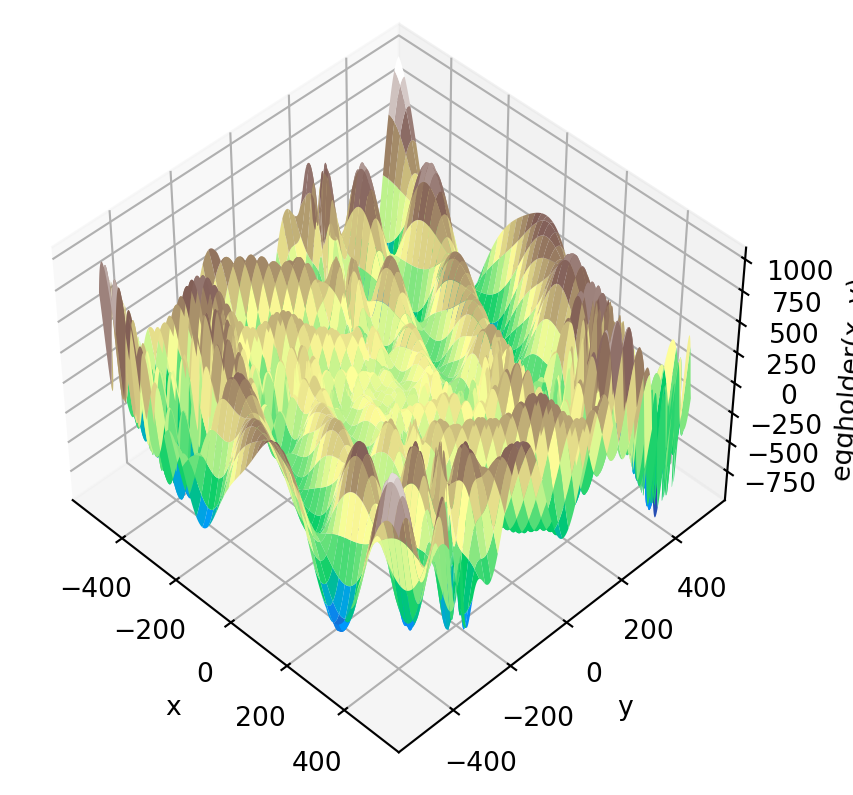

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = np.arange(-512, 513)
y = np.arange(-512, 513)
xgrid, ygrid = np.meshgrid(x, y)
xy = np.stack([xgrid, ygrid])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(45, -45)
ax.plot_surface(xgrid, ygrid, eggholder(xy), cmap='terrain')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('eggholder(x, y)')
plt.show()

We now use the global optimizers to obtain the minimum and the function value at the minimum. We’ll store the results in a dictionary so we can compare different optimization results later.


In [12]:
from scipy import optimize
results = dict()
results['shgo'] = optimize.shgo(eggholder, bounds)
results['shgo']

 message: Optimization terminated successfully.
 success: True
     fun: -935.3379515605789
    funl: [-9.353e+02]
       x: [ 4.395e+02  4.540e+02]
      xl: [[ 4.395e+02  4.540e+02]]
     nit: 1
    nfev: 45
   nlfev: 40
   nljev: 10
   nlhev: 0

In [13]:
results['DA'] = optimize.dual_annealing(eggholder, bounds)
results['DA']

 message: ['Maximum number of iteration reached']
 success: True
  status: 0
     fun: -935.3379515605568
       x: [ 4.395e+02  4.540e+02]
     nit: 1000
    nfev: 4061
    njev: 20
    nhev: 0

All optimizers return an `OptimizeResult`,
which in addition to the solution contains information on the number of function evaluations, whether the optimization was successful, and more. For brevity, we won’t show the full output of the other optimizers:


In [14]:
results['DE'] = optimize.differential_evolution(eggholder, bounds)
results['DE']

 message: Optimization terminated successfully.
 success: True
     fun: -959.6406627208469
       x: [ 5.120e+02  4.042e+02]
     nit: 47
    nfev: 1452
     jac: [-3.386e+00  0.000e+00]

`shgo` has a second method, which returns all local minima rather than only what it thinks is the global minimum:


In [15]:
results['shgo_sobol'] = optimize.shgo(eggholder, bounds, n=200, iters=5,
                                      sampling_method='sobol')
results['shgo_sobol']

 message: Optimization terminated successfully.
 success: True
     fun: -959.640662720831
    funl: [-9.596e+02 -9.353e+02 ... -6.591e+01 -6.387e+01]
       x: [ 5.120e+02  4.042e+02]
      xl: [[ 5.120e+02  4.042e+02]
           [ 4.395e+02  4.540e+02]
           ...
           [ 3.165e+01 -8.523e+01]
           [ 5.865e+01 -5.441e+01]]
     nit: 5
    nfev: 3529
   nlfev: 2327
   nljev: 634
   nlhev: 0

We’ll now plot all found minima on a heatmap of the function:


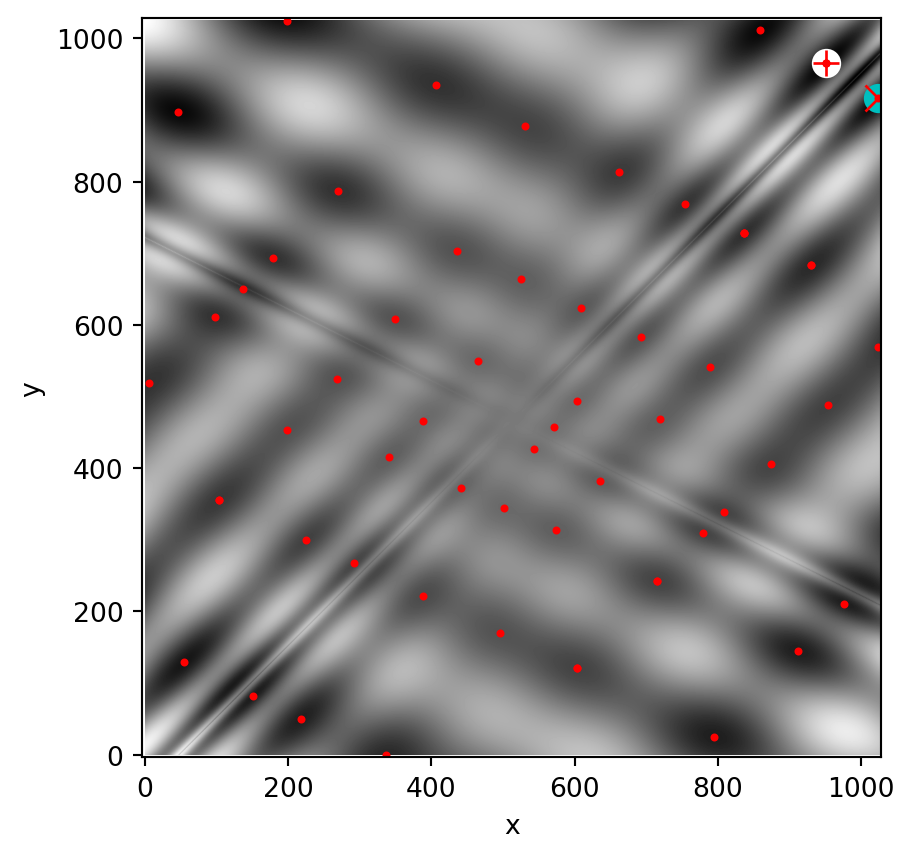

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(eggholder(xy), interpolation='bilinear', origin='lower',
               cmap='gray')
ax.set_xlabel('x')
ax.set_ylabel('y')

def plot_point(res, marker='o', color=None):
    ax.plot(512+res.x[0], 512+res.x[1], marker=marker, color=color, ms=10)

plot_point(results['DE'], color='c')  # differential_evolution - cyan
plot_point(results['DA'], color='w')  # dual_annealing.        - white

# SHGO produces multiple minima, plot them all (with a smaller marker size)
plot_point(results['shgo'], color='r', marker='+')
plot_point(results['shgo_sobol'], color='r', marker='x')
for i in range(results['shgo_sobol'].xl.shape[0]):
    ax.plot(512 + results['shgo_sobol'].xl[i, 0],
            512 + results['shgo_sobol'].xl[i, 1],
            'ro', ms=2)

ax.set_xlim([-4, 514*2])
ax.set_ylim([-4, 514*2])
plt.show()

### Dual Annealing Optimization

This function implements the Dual Annealing optimization.

### Differential Evolution

Differential Evolution is an algorithm used for finding the global minimum of multivariate functions. It is stochastic in nature (does not use gradient methods), and can search large areas of candidate space, but often requires larger numbers of function evaluations than conventional gradient based techniques.

### DIRECT

DIviding RECTangles (DIRECT) is a deterministic global optimization algorithm capable of minimizing a black box function with its variables subject to lower and upper bound constraints by sampling potential solutions in the search space

### SHGO

SHGO stands for "simplicial homology global optimization".
It is considered appropriate for solving general purpose NLP and blackbox optimization problems to global optimality (low-dimensional problems).


### Basin-hopping

Basin-hopping is a two-phase method that combines a global stepping algorithm with local minimization at each step. Designed to mimic the natural process of energy minimization of clusters of atoms, it works well for similar problems with “funnel-like, but rugged” energy landscapes

## Project: One-Mass Oscillator Optimization


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

### Introduction

In this project, you will apply various optimization algorithms to fit a one-mass oscillator model to real-world data. The objective is to minimize the sum of the squared residuals between the model predictions and the observed amplitudes of a one-mass oscillator system across different frequencies.

### One-Mass Oscillator Model

The one-mass oscillator is characterized by the following equation, representing the amplitudes of the system:

$$
V(\omega) = \frac{F}{\sqrt{(1 - \nu^2)^2 + 4D^2\nu^2}}
$$

Here,
$\omega$ represents the angular frequency of the system, $\nu$ is the ratio of the excitation frequency to the natural frequency, i.e.,
$$
\nu = \frac{\omega_{\text{err}}}{\omega_{\text{eig}}},
$$
$D$ is the damping ratio,
and $F$ is the force applied to the system.

The goal of the project is to determine the optimal values for the parameters $\omega_{\text{eig}}$, $D$, and $F$
that result in the best fit of the one-mass oscillator model to the observed amplitudes.


### The Real-World Data

There are two different measurements. `J` represents the measured frequencies, and `N` represents the measured amplitudes.


In [18]:
df1 = pd.read_pickle("./data/Hcf.d/df1.pkl")
df2 = pd.read_pickle("./data/Hcf.d/df2.pkl")
df1.describe()

,J,N
count,33.000000,33.000000
mean,8148.750252,10.430887
std,6.870023,2.846469
min,8137.649210,4.698761
25%,8143.799766,8.319253
50%,8146.942295,10.152119
75%,8153.934051,13.407260
max,8162.504002,14.382749


In [19]:
df1.head()

,J,N
14999,8162.504002,5.527511
15011,8156.384831,7.359789
15016,8159.199238,6.532958
15020,8159.200889,5.895933
15025,8153.934051,9.326749


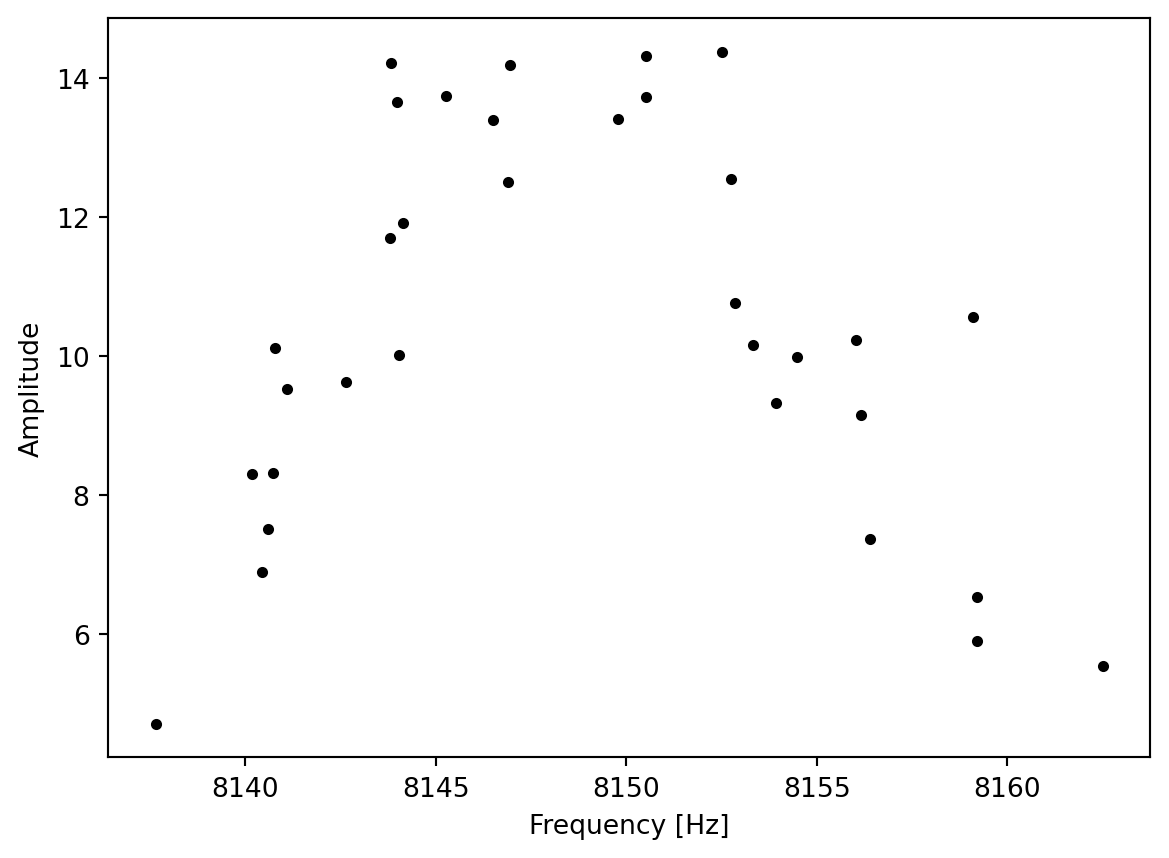

In [20]:
# plot the data, i.e., the measured amplitudes as a function of the measured frequencies
plt.scatter(df1["J"], df1["N"], color="black", label="Spektralpunkte", zorder=5, s=10)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.show()

Note: Low amplitudes distort the fit and are negligible therefore we define a lower threshold for `N`.


In [21]:
threshold = 0.4
df1.sort_values("N")
max_N = max(df1["N"])
df1 = df1[df1["N"]>=threshold*max_N]

We extract the frequency value for maximum value of the amplitude. This serves as the initial value for one decision variable.


In [22]:
df_max=df1[df1["N"]==max(df1["N"])]
initial_Oeig = df_max["J"].values[0]
max_N = df_max["N"].values[0]

We also have to define the other two initial guesses for the damping ratio and the force, e.g.,


In [23]:
initial_D = 0.006
initial_F = 0.120
initial_values = [initial_Oeig, initial_D, initial_F]

Additionally, we define the bounds for the decision variables:


In [24]:
min_Oerr = min(df1["J"])
max_Oerr = max(df1["J"])

In [25]:
bounds = [(min_Oerr, max_Oerr), (0, 0.03), (0, 1)]

### Objective Function

Then we define the objective function:


In [26]:
def one_mass_oscillator(params, Oerr) -> np.ndarray:
    # returns amplitudes of the system
    # Defines the model of a one mass oscilator 
    Oeig, D, F = params
    nue = Oerr / Oeig
    V = F / (np.sqrt((1 - nue**2) ** 2 + (4 * D**2 * nue**2)))
    return V

In [27]:
def objective_function(params, Oerr, amplitudes) -> np.ndarray:
    # objective function to compare calculated and real amplitudes
    return np.sum((amplitudes - one_mass_oscillator(params, Oerr)) ** 2)

We define the options for the optimzer and start the optimization process:


In [28]:
options = {
    "maxfun": 100000,
    "ftol": 1e-9,
    "xtol": 1e-9,
    "stepmx": 10,
    "eta": 0.25,
    "gtol": 1e-5}

In [29]:
J = np.array(df1["J"]) # measured frequency
N = np.array(df1["N"]) # measured amplitude

In [30]:
result = minimize(
    objective_function,
    initial_values,
    args=(J, N),
    method='Nelder-Mead',
    bounds=bounds,
    options=options)

/var/folders/dw/pvtj6mt91znd0hftcztqb0k00000gn/T/ipykernel_70407/4167102507.py:1: OptimizeWarning:

Unknown solver options: maxfun, ftol, xtol, stepmx, eta, gtol



### Results

We can observe the results:


In [31]:
# map optimized values to variables
resonant_frequency = result.x[0]
D = result.x[1]
F = result.x[2]
# predict the resonant amplitude with the fitted one mass oscillator.
X_pred = np.linspace(min_Oerr, max_Oerr, 1000)
ypred_one_mass_oscillator = one_mass_oscillator(result.x, X_pred)
resonant_amplitude = max(ypred_one_mass_oscillator)
print(f"result: {result}")

result:        message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 53.5414407415841
             x: [ 8.148e+03  7.434e-04  2.153e-02]
           nit: 99
          nfev: 175
 final_simplex: (array([[ 8.148e+03,  7.434e-04,  2.153e-02],
                       [ 8.148e+03,  7.435e-04,  2.153e-02],
                       [ 8.148e+03,  7.435e-04,  2.153e-02],
                       [ 8.148e+03,  7.435e-04,  2.153e-02]]), array([ 5.354e+01,  5.354e+01,  5.354e+01,  5.354e+01]))


Finally, we can plot the optimized fit and the real values:


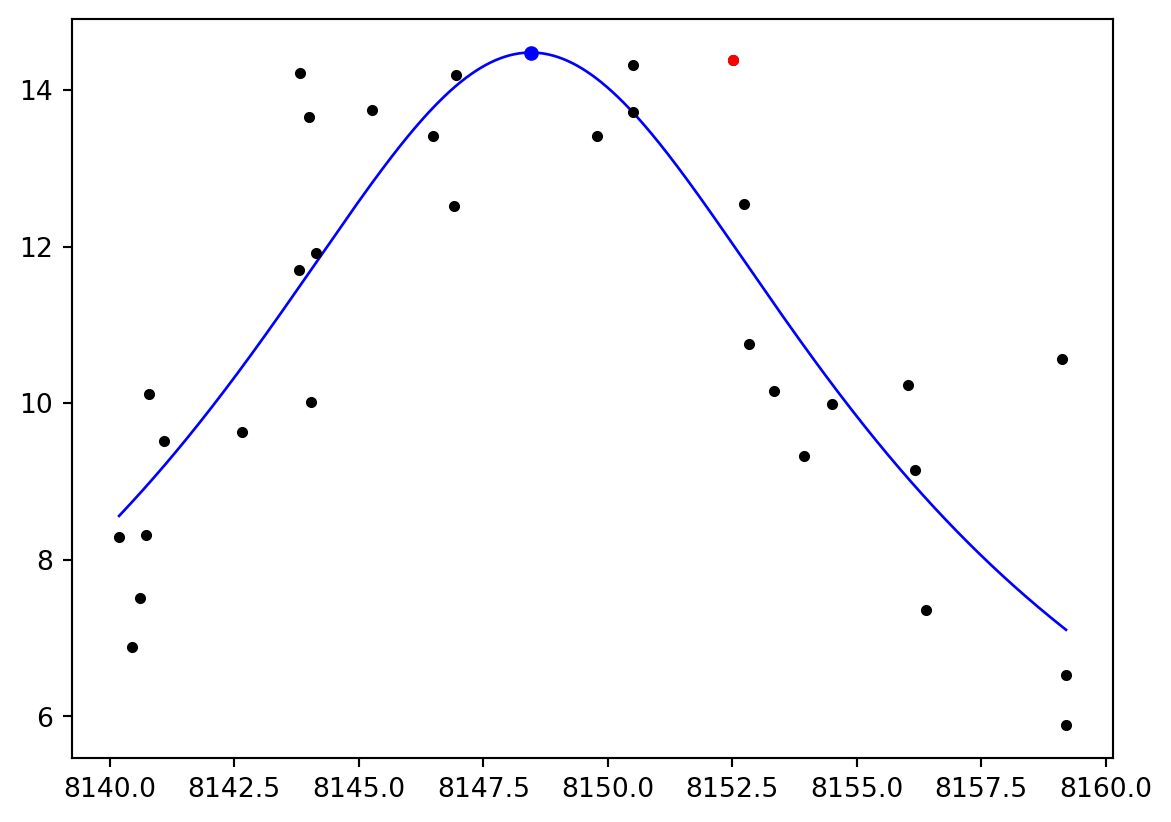

In [32]:
plt.scatter(
    df1["J"],
    df1["N"],
    color="black",
    label="Spektralpunkte filtered",
    zorder=5,
    s=10,
)
# color the max amplitude point red
plt.scatter(
    initial_Oeig,
    max_N,
    color="red",
    label="Max Amplitude",
    zorder=5,
    s=10,
)

plt.plot(
        X_pred,
        ypred_one_mass_oscillator,
        label="Alpha",
        color="blue",
        linewidth=1,
    )
plt.scatter(
    resonant_frequency,
    resonant_amplitude,
    color="blue",
    label="Max Curve Fit",
    zorder=10,
    s=20,
)

### Task for the Project Work

::: {.callout-note}
### Task

* Experiment with various optimizers to identify the optimal parameter setup for the one-mass oscillator model and both data frames.
* Please explain your thoughts and ideas, and subsequently compare the results obtained from different optimizers.
:::


## Jupyter Notebook

:::{.callout-note}

* The Jupyter-Notebook of this lecture is available on GitHub in the [Hyperparameter-Tuning-Cookbook Repository](https://github.com/sequential-parameter-optimization/Hyperparameter-Tuning-Cookbook/blob/main/003_scipy_optimize_intro.ipynb)

:::